# With Naver movie review

## Preprocessing

In [7]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 299 kB/s  eta 0:00:01
     |████████████████████████████████| 86 kB 3.2 MB/s  eta 0:00:01
     |████████████████████████████████| 457 kB 24.6 MB/s eta 0:00:01
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.9.0
    Uninstalling beautifulsoup4-4.9.0:
      Successfully uninstalled beautifulsoup4-4.9.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [8]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### data load & EDA

In [21]:
train_data = pd.read_table('../input/naver-movie-review-dataset/ratings_train.txt', sep='\t')
test_data = pd.read_table('../input/naver-movie-review-dataset/ratings_test.txt', sep='\t')

In [22]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [23]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


In [24]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 50000


In [25]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [26]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [27]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


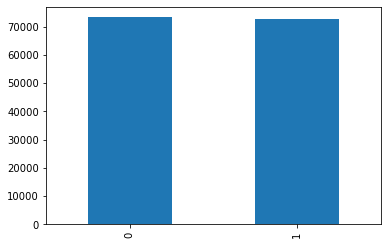

In [28]:
train_data['label'].value_counts().plot(kind = 'bar')

### 결측치 제거

In [29]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [30]:
# Null 제거
train_data = train_data.dropna(how='any')

In [31]:
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거

### 토큰화

In [32]:
stopwords = ['의','가','이','은','들','는','좀','잘','과','도','를','으로','자','에','와','한','하다']

In [33]:
okt = Okt() # 형태소 분석기

In [34]:
X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True)# 토큰화
    temp_X = [word for word in temp_X if not word in stopwords]# 불용어 제거
    X_train.append(temp_X)

In [35]:
print(X_train[:3])

[['아', '더빙', '..', '진짜', '짜증나다', '목소리'], ['흠', '...', '포스터', '보고', '초딩', '영화', '줄', '....', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [36]:
X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

### 정수인코딩

In [37]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [38]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총합

In [39]:
# key: 단어, value : 빈도수
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if(value < threshold):
        rare_cnt += 1
        rare_freq += value
        
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 49587
등장 빈도가 2번 이하인 희귀 단어의 수: 28787
단어 집합에서 희귀 단어의 비율: 58.053522092483924
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.9085069486847568


In [40]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 20802


In [41]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [28]:
print(X_train[:3])

[[57, 489, 5, 22, 281, 706], [965, 7, 490, 51, 651, 3, 234, 44, 1531, 30, 1015, 724, 27], [406, 2574, 1, 5305, 6621, 4, 241, 15]]


In [29]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

### 빈 샘플 제거

In [30]:
# 빈 샘플 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [31]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

146181
146181


### 패딩

리뷰의 최대 길이 : 95
리뷰의 평균 길이 : 12.60379255854044


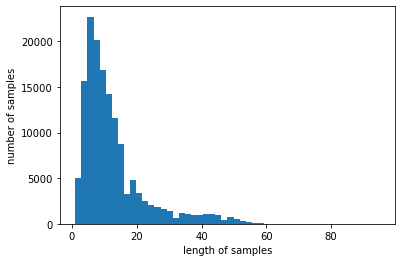

In [32]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [44]:
max_len = 30

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## LSTM

In [2]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [35]:
def create_model():
    model = Sequential()
    model.add(Embedding(vocab_size,100))
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    
    return model

In [36]:
model = create_model()

In [37]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [38]:
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1827/1828 [============================>.] - ETA: 0s - loss: 0.3829 - acc: 0.8275
Epoch 00001: val_acc improved from -inf to 0.85081, saving model to best_model.h5
1828/1828 [==============================] - 108s 59ms/step - loss: 0.3829 - acc: 0.8276 - val_loss: 0.3420 - val_acc: 0.8508
Epoch 2/15
1828/1828 [==============================] - ETA: 0s - loss: 0.3166 - acc: 0.8643
Epoch 00002: val_acc improved from 0.85081 to 0.86172, saving model to best_model.h5
1828/1828 [==============================] - 106s 58ms/step - loss: 0.3166 - acc: 0.8643 - val_loss: 0.3257 - val_acc: 0.8617
Epoch 3/15
1827/1828 [============================>.] - ETA: 0s - loss: 0.2890 - acc: 0.8788
Epoch 00003: val_acc did not improve from 0.86172
1828/1828 [==============================] - 105s 58ms/step - loss: 0.2890 - acc: 0.8788 - val_loss: 0.3263 - val_acc: 0.8615
Epoch 4/15
1827/1828 [============================>.] - ETA: 0s - loss: 0.2696 - acc: 0.8890
Epoch 00004: val_acc improved fro

In [3]:
loaded_model = load_model('../input/n-model/naver_review.h5')

In [45]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [46]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

96.49% 확률로 긍정 리뷰입니다.



In [47]:
nomad_df = pd.read_csv('../input/nomadcoders-review-dataset/review.csv')

In [56]:
for i in range(1000):
    print(i)
    sentiment_predict(nomad_df['review_text'][i])

0
90.82% 확률로 긍정 리뷰입니다.

1
95.34% 확률로 긍정 리뷰입니다.

2
91.47% 확률로 긍정 리뷰입니다.

3
81.51% 확률로 긍정 리뷰입니다.

4
96.88% 확률로 긍정 리뷰입니다.

5
98.81% 확률로 긍정 리뷰입니다.

6
95.36% 확률로 긍정 리뷰입니다.

7
98.82% 확률로 긍정 리뷰입니다.

8
62.87% 확률로 부정 리뷰입니다.

9
98.18% 확률로 긍정 리뷰입니다.

10
88.79% 확률로 긍정 리뷰입니다.

11
97.63% 확률로 긍정 리뷰입니다.

12
99.64% 확률로 긍정 리뷰입니다.

13
99.72% 확률로 긍정 리뷰입니다.

14
83.33% 확률로 긍정 리뷰입니다.

15
98.58% 확률로 긍정 리뷰입니다.

16
71.01% 확률로 긍정 리뷰입니다.

17
68.92% 확률로 긍정 리뷰입니다.

18
74.92% 확률로 부정 리뷰입니다.

19
99.61% 확률로 긍정 리뷰입니다.

20
77.48% 확률로 부정 리뷰입니다.

21
98.02% 확률로 긍정 리뷰입니다.

22
72.37% 확률로 긍정 리뷰입니다.

23
99.56% 확률로 긍정 리뷰입니다.

24
99.29% 확률로 긍정 리뷰입니다.

25
99.65% 확률로 긍정 리뷰입니다.

26
99.54% 확률로 긍정 리뷰입니다.

27
99.46% 확률로 긍정 리뷰입니다.

28
98.51% 확률로 긍정 리뷰입니다.

29
99.21% 확률로 긍정 리뷰입니다.

30
99.30% 확률로 긍정 리뷰입니다.

31
98.58% 확률로 긍정 리뷰입니다.

32
93.24% 확률로 부정 리뷰입니다.

33
98.82% 확률로 긍정 리뷰입니다.

34
67.34% 확률로 긍정 리뷰입니다.

35
63.05% 확률로 긍정 리뷰입니다.

36
99.49% 확률로 긍정 리뷰입니다.

37
98.56% 확률로 긍정 리뷰입니다.

38
91.44% 확률로 긍정 리뷰입니다.

39
91.95% 확률로 긍정 리뷰입니다.

40
98.99% 

95.30% 확률로 긍정 리뷰입니다.

321
68.66% 확률로 부정 리뷰입니다.

322
67.98% 확률로 긍정 리뷰입니다.

323
99.39% 확률로 긍정 리뷰입니다.

324
98.31% 확률로 긍정 리뷰입니다.

325
70.56% 확률로 긍정 리뷰입니다.

326
99.62% 확률로 긍정 리뷰입니다.

327
55.54% 확률로 긍정 리뷰입니다.

328
99.57% 확률로 긍정 리뷰입니다.

329
99.27% 확률로 긍정 리뷰입니다.

330
98.26% 확률로 긍정 리뷰입니다.

331
97.73% 확률로 긍정 리뷰입니다.

332
99.30% 확률로 긍정 리뷰입니다.

333
73.41% 확률로 긍정 리뷰입니다.

334
99.73% 확률로 긍정 리뷰입니다.

335
99.16% 확률로 긍정 리뷰입니다.

336
50.04% 확률로 부정 리뷰입니다.

337
99.02% 확률로 긍정 리뷰입니다.

338
96.89% 확률로 긍정 리뷰입니다.

339
99.57% 확률로 긍정 리뷰입니다.

340
80.15% 확률로 긍정 리뷰입니다.

341
98.74% 확률로 긍정 리뷰입니다.

342
90.79% 확률로 부정 리뷰입니다.

343
84.13% 확률로 부정 리뷰입니다.

344
98.68% 확률로 긍정 리뷰입니다.

345
99.38% 확률로 긍정 리뷰입니다.

346
98.01% 확률로 긍정 리뷰입니다.

347
96.98% 확률로 긍정 리뷰입니다.

348
54.40% 확률로 긍정 리뷰입니다.

349
88.42% 확률로 부정 리뷰입니다.

350
97.49% 확률로 긍정 리뷰입니다.

351
89.90% 확률로 부정 리뷰입니다.

352
93.47% 확률로 긍정 리뷰입니다.

353
86.92% 확률로 긍정 리뷰입니다.

354
98.82% 확률로 긍정 리뷰입니다.

355
88.22% 확률로 긍정 리뷰입니다.

356
99.34% 확률로 긍정 리뷰입니다.

357
92.68% 확률로 긍정 리뷰입니다.

358
97.91% 확률로 긍

KeyError: 556

In [ ]:
18 93 133 136 192 243 246 273

In [ ]:
i

In [64]:
nomad_df.iloc[np.r_[18, 93, 133, 136, 192, 243, 246, 273],:]

,lecture_name,term,review_text
18,바닐라,1기,부터 일해야돼 흙흙흙
93,코코아,3기,챌린지를 시작하면서 업무가 바빠지면서 회사에서 쉬는 시간에 틈틈히 하겠다는 시도는...
133,코코아,4기,2주가 순식간에 지나가버렸어요. 새벽까지 챌린지 과제하느라 힘들었지만 그냥 강의만 ...
136,코코아,5기,처음엔 가벼운 마음으로 시작했는데 하루하루 지날 수록 과제도 어려워지고 시간도 오래...
192,코코아,7기,챌린지를 진행하는것이 단순히 영상을 3번 돌려보며 따라서 타이핑 하는것보다 3배 ...
243,코코아,9기,하루 12시간 일하고 퇴근해서 다시 10시간 넘게 코딩강의 보고 또 과제까지 제출했...
246,코코아,9기,작년 강의를 80% 정도 듣다가 그만뒀었는데 챌린지 진행하면서 완강 할 수 있어서...
273,바닐라,1기,왕초보라서 갓갓님들처럼 만들지는 못하지만 그래도 자꾸 반복적으로하니 조금이라도 익숙...


In [ ]:
nomad_df.iloc[93,:]